# Bag of Words

This notebook evaluates methods for Bag of words document representation using the [academia.stackexchange.com](https://academia.stackexchange.com/) data dump.

## Table of Contents
* [Data import](#data_import)
* [Bag of words](#bow)
* [Experiments](#experiments)
* [Evaluation](#evaluation)
* [Dimension Reduction](#dim_reduce)

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import time

ggplot_styles = {
    'axes.axisbelow': 'True',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.grid.axis': 'y',
    'figure.figsize': (16, 8),
    'font.size': 18, 
    'grid.color': 'gainsboro',
    'grid.linewidth': 0.5,
    'lines.linestyle': '-',
    'lines.linewidth': 0.7,
}
plt.rcParams.update(ggplot_styles)

<a id='data_import'/>

## Data Import

In [2]:
from academia_tag_recommender.experiments.data import ExperimentalData

ed = ExperimentalData.load()
X, _, _, _ = ed.get_train_test_set()

<a id='bow'/>

## Bag of words

Bag of words is a text transformation approach (also called feature extraction), where each document is represented as a vector. The vector has the size of all documents in the corpus. Each entry in the vector stands for one word token in the corpus. Tokens that are not represented in the document have 0 as the entry. For tokens that are represented in the corpus, there are different options to choose how to represent those tokens.

**Count** 
    
The *count* describes how often the token appears in the document (absolute).
    
**Term-frequency times inverse document-frequency (tfidf)**
    
Where *term-frequency* describes how often the token appears in the document (normalized) and *document-frequency* describes the overall occurence of a term in the corpus.

<a id='experiments'/>

### Experiments

The effects of the different BoWs approaches can be shown by evaluating the text transformations. Different [preprocessing](2.0-me-document-representation.ipynb) can be used for comparison purposes.


**Preprocessing**
* Preprocessor [`None`, `BasicPreprocessor`]
* Normalization [`None`, `BasicTokenizer`, `EnglishStemmer`, `PorterStemmer`, `LancasterStemmer`, `Lemmatizer`]

**BoW**
* Vectorizer [`CountVectorizer`, `TfidfVectorizer`]

In [3]:
from academia_tag_recommender.preprocessor import BasicPreprocessor
from academia_tag_recommender.tokenizer import BasicTokenizer, EnglishStemmer, PorterStemmer, LancasterStemmer, Lemmatizer
from academia_tag_recommender.stopwords import stopwordlist
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [4]:
vectorizers = [CountVectorizer, TfidfVectorizer]
preprocessors = [None, BasicPreprocessor()]
tokenizers = [None, BasicTokenizer(), EnglishStemmer(), PorterStemmer(), LancasterStemmer(), Lemmatizer()]
vectorizers_names = [vectorizer.__name__ for vectorizer in vectorizers]
preprocessors_names = [type(preprocessor).__name__ for preprocessor in preprocessors]
tokenizers_names = [type(tokenizer).__name__ for tokenizer in tokenizers]

results = []

for i_v, v in enumerate(vectorizers):
    for i_p, p in enumerate(preprocessors):
        for i_t, t in enumerate(tokenizers):
            vectorizer = v(min_df=2, tokenizer=t, preprocessor=p, stop_words=stopwordlist, ngram_range=(1, 1))
            start = time.time()
            features = vectorizer.fit_transform(X)
            end = time.time()
            process_time = end-start
            shape = features.shape
            idf = vectorizer.idf_ if v == TfidfVectorizer else None
            results.append([vectorizers_names[i_v], preprocessors_names[i_p], tokenizers_names[i_t], process_time, shape, idf])

<a id='evaluation'/>

## Evaluation

While fitting the document representation models we save some computation results (e.g. processing time) to compare the methods afterwards.

This is just a basic evaluation regarding performance and feature vector size. The *best* document representation model can only be determined after classification.

**Shape and Processing Time**

We examine the shape and processing time of the feature vectors depending on the *Tokenizer* and the *Preprocessor* that is used..

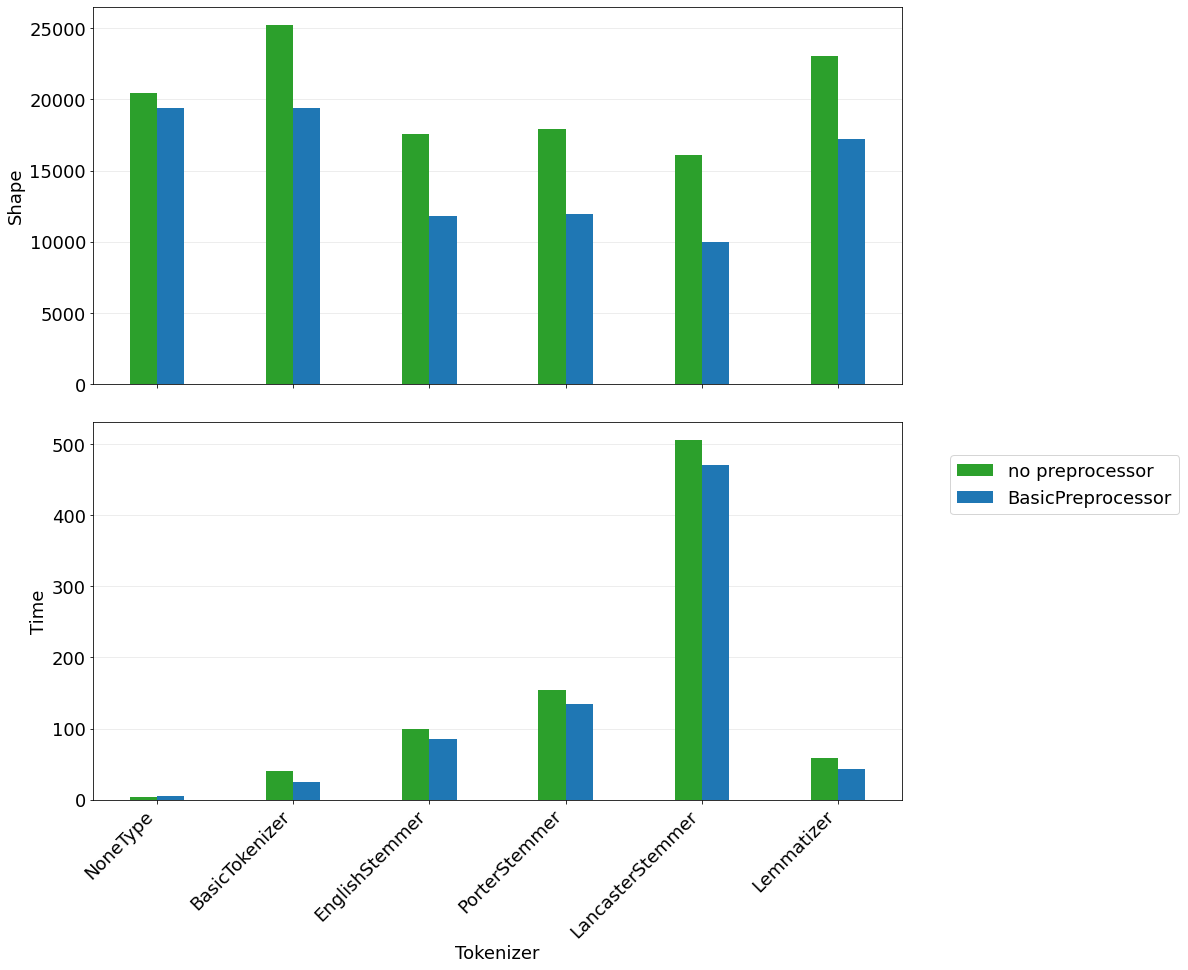

In [5]:
def feat_with_values(feature, p):
    filtered_results = [result for result in results if result[0] == vectorizers_names[1] and result[1] == p]
    if feature == 'shape':
        return [result[4][1] for result in filtered_results]
    elif feature == 'time':
        return [result[3] for result in filtered_results]        
                 
x = np.arange(len(tokenizers))
bar_width = 0.20

fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)

def bar_with_feat(feature, ax):
    ax.bar(x - bar_width/2, feat_with_values(feature, preprocessors_names[0]), bar_width, label='no preprocessor', color='tab:green')
    ax.bar(x + bar_width/2, feat_with_values(feature, preprocessors_names[1]), bar_width, label='BasicPreprocessor')
    ax.set_ylabel('{}'.format(feature.capitalize()))
    ax.set_xticks(x)
    ax.set_xticklabels(tokenizers_names, rotation=45, ha='right')
    #ax.legend()
    
bar_with_feat('shape', axes[0])
bar_with_feat('time', axes[1])
axes[1].set_xlabel('Tokenizer')
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc='right')
plt.subplots_adjust(wspace=0.5, right=0.75)

plt.show()

Looking at the graphs we see that the *preprocessor* used by the nltk implementation does lead to more features while usually having a longer processing time than the BasicPreprocessor.

We see a big difference in the processing time of the *tokenizers*, where no tokenizer is obviously the fastest. While the `EnglishStemmer` and the `PorterStemmer`seem to lead to the same amount of features, the `PorterStemmer` does need much more time compute. 

The `LancasterStemmer` takes by far the longest processing time.

**TfidfVectorizer**

To explore the effect of the inverse document frequency of the `TfidfVectorizer` we compare the numerical values of the features.

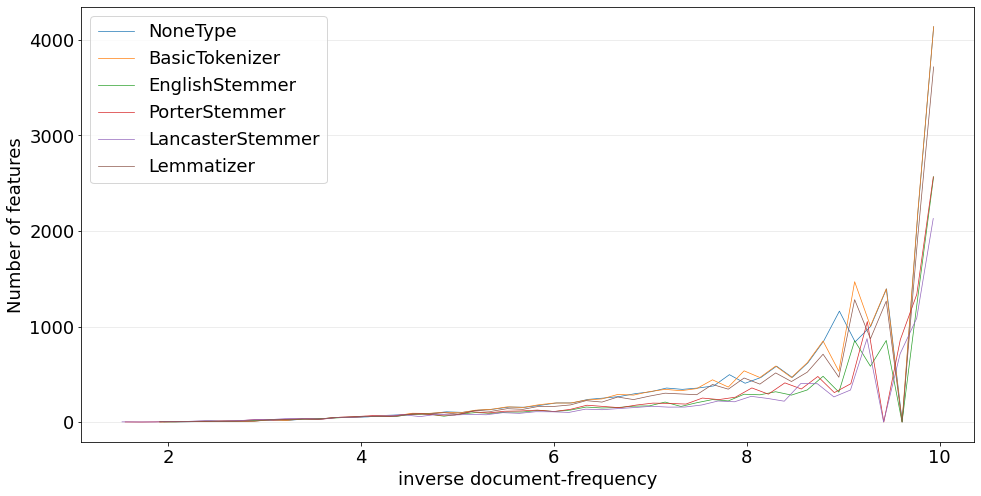

In [6]:
fig, ax = plt.subplots()

histograms = []
for t in tokenizers_names:
    idfs = [result[5] for result in results if result[0] == vectorizers_names[1] and result[1] == preprocessors_names[1] and result[2] == t]
    y, binEdges = np.histogram(idfs, bins=50)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    ax.plot(bincenters, y, marker='None')

ax.set_xlabel('inverse document-frequency')
ax.set_ylabel('Number of features')
ax.legend(tokenizers_names)

plt.show()

Most of the features have an inverse document-frequency larger than 6. That means they appear in a lot of documents and do not have a high representational value. Therefore the TfIdfVectorizer can bring their values close to zero and improve computational expense.

**Count vs. Tfidf**

To see the above stated effect clearlier we investigate the feature values of the document representation models.

We first define the value ranges we want to inspect.

In [7]:
ranges = [(1, 1), (2, 10), (11, 100), (101, 1000), (1001, 10000), (10001, 100000), (1001, 2000), (2001, 3000), (3001, 4000), (4001, 5000), (5001, 6000), (6001, 7000), (7001, 8000), (8001, 9000), (9001, 10000), (10001, 100000)]

Afterwards we define some functions that help us examine the features for a given model.

In [8]:
def get_number_of_values_in_range(data: list, range_: tuple) -> int:
    return len([value for _, value in data if value >= range_[0] and value <= range_[1]])

def get_statistics_for(data: list) -> dict:
    stats = {}
    stats['features'] = len(data)
    stats['min'] = data[-1][1]
    stats['max'] = data[0][1]
    for range_ in ranges:
        stats['[{}-{}]'.format(*range_)] = get_number_of_values_in_range(data, range_)
    return stats

def get_summed_values(vocabulary, features):
    sum_words = features.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vocabulary]
    return list(sorted(words_freq, key = lambda x: x[1], reverse=True))

def analyze(vectorizer):
    features = vectorizer.fit_transform(X)
    summed_values = get_summed_values(vectorizer.vocabulary_.items(), features)
    return get_statistics_for(summed_values)

In [9]:
stats = {'CountVectorizer': {}, 'TfidfVectorizer': {}}
for i_t, tokenizer in enumerate(tokenizers):
    stats['CountVectorizer'][tokenizers_names[i_t]] = analyze(TfidfVectorizer(min_df=2, tokenizer=tokenizer, preprocessor=BasicPreprocessor(), stop_words=stopwordlist, ngram_range=(1, 1)))
    stats['TfidfVectorizer'][tokenizers_names[i_t]] = analyze(CountVectorizer(min_df=2, tokenizer=tokenizer, preprocessor=BasicPreprocessor(), stop_words=stopwordlist, ngram_range=(1, 1)))

In [10]:
def print_stats_for(vectorizer: str):
    print('\nStats for {}'.format(vectorizer))
    print_string = '{:<15}' + ''.join(['{:<15}' for t in tokenizers_names])
    print(print_string.format(*(['Range']+tokenizers_names)))
    print(print_string.format(*(['Features']+[stats[vectorizer][t]['features'] for t in tokenizers_names])))
    for range_ in ranges:
        key = '[{}-{}]'.format(*range_)
        print(print_string.format(*([key]+[stats[vectorizer][t][key] for t in tokenizers_names])))

In [11]:
print_stats_for('CountVectorizer')
print_stats_for('TfidfVectorizer')


Stats for CountVectorizer
Range          NoneType       BasicTokenizer EnglishStemmer PorterStemmer  LancasterStemmerLemmatizer     
Features       19399          19398          11809          11939          9964           17182          
[1-1]          0              0              0              0              0              0              
[2-10]         4341           4342           2553           2590           2121           3845           
[11-100]       2270           2270           1616           1643           1427           2055           
[101-1000]     294            294            367            362            387            311            
[1001-10000]   0              0              1              1              2              0              
[10001-100000] 0              0              0              0              0              0              
[1001-2000]    0              0              1              1              2              0              
[2001-3000]    0  

For the defined ranges we print how many features have summed counts inside the range.

When comparing the `CountVectorizer` to the `TfidfVectorizer` we see again, that it prevents the values from getting too big resulting in more feature values that are small. When fitting the categorizer models we might benefit from smaller values computationwise.